# DATASCI W261: Machine Learning at Scale
## Assignment Week 2
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 25-Jan-2016 9pm

### HW2.0:

#### What is a race condition in the context of parallel computation? Give an example.
A race condition is when a section of code is executed by multiple processes, and the order in which the processes execute will impact the final result. In the below example, if two threads read data concurrently, then the data only gets incremented once. However, if the two threads read data sequentially, the data gets incremented by 2. 

![Race condition example](race_conditions.png)
Source: https://en.wikipedia.org/wiki/Race_condition#Example

#### What is MapReduce?
MapReduce can refer to multiple concepts:
- **Programming model:** Processes are split into a "mapping" phase, and a "reducing" phase. In the map phase, a certain function is mapped on to each value in a data set, and then in the reduce phase, the result of the map phase is aggregated. 
- **Execution framework:** This framework coordinates running processes written with the above model in mind.
- **Software implementation:** MapReduce is the name of Google's proprietary implementation of this programming model, while Apache Hadoop is the open-source implementation.

#### How does it differ from Hadoop?
Hadoop is the open-source implementation of Google's MapReduce. Hadoop consists of two parts: distributed storage of data, and distributed processing of data. HDFS is the storage part, and MapReduce is the processing part.

#### Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.
Hadoop is based on the MapReduce paradigm. The classic example of the MapReduce programming paradigm is word count. In the map phase of word count, each word in a document is assigned a count of 1. In the reduce phase, the counts for each unique word are summed to yield the final count of each word.

In [16]:
def hw2_0():
    doc = "Hello this is a test to test word count test should have a count of three".lower()
    key_vals = []
    
    print "MAP PHASE"
    for word in doc.split():
        print [word, 1]
        key_vals.append([word, 1])
    
    print "\nREDUCE PHASE"
    key_vals = sorted(key_vals)
    
    current_word = None
    current_count = 0
    
    for pair in key_vals:
        if current_word == pair[0]:
            print [current_word, current_count], "(intermediate step)"
            current_count += pair[1]
        else:
            if current_word:
                print [current_word, current_count], "FINAL SUM"
            current_word = pair[0]
            current_count = pair[1]

    print [current_word, current_count], "FINAL SUM"
    
hw2_0()

MAP PHASE
['hello', 1]
['this', 1]
['is', 1]
['a', 1]
['test', 1]
['to', 1]
['test', 1]
['word', 1]
['count', 1]
['test', 1]
['should', 1]
['have', 1]
['a', 1]
['count', 1]
['of', 1]
['three', 1]

REDUCE PHASE
['a', 1] (intermediate step)
['a', 2] FINAL SUM
['count', 1] (intermediate step)
['count', 2] FINAL SUM
['have', 1] FINAL SUM
['hello', 1] FINAL SUM
['is', 1] FINAL SUM
['of', 1] FINAL SUM
['should', 1] FINAL SUM
['test', 1] (intermediate step)
['test', 2] (intermediate step)
['test', 3] FINAL SUM
['this', 1] FINAL SUM
['three', 1] FINAL SUM
['to', 1] FINAL SUM
['word', 1] FINAL SUM


### HW2.1: Sort in Hadoop MapReduce
**Given as input: Records of the form `<integer, “NA”>`, where integer is any integer, and “NA” is just the empty string.**<br>
**Output: Sorted key value pairs of the form `<integer, “NA”>`; what happens if you have multiple reducers? Do you need additional steps? Explain.**

If there are multiple reducers, then a straightforward MapReduce process will yield outputs that are sorted within each reducer, but not sorted across all reducers. The easy, not-scalable solution is to force the job to have only one reducer.

In order to output a sort across more than one reducer, an extra step needs to be implemented that will intelligently send keys to reducers so that the result from all reducers will yield a complete sort. For example, let's say our keys ranged from 0-300. If we had 3 reducers, we could send all keys in the range [0,100) to reducer 1, [100, 200) to reducer 2, and [200, 300] to reducer 3. Thus, the output of each reducer will yield documents that are completely sorted. We would need to balance the keys sent to each reducer to ensure that the load is still balanced between all reducers, which will require some calculations.

In this homework, the data set is relatively small, so we can get away with specifying one reducer.

Another strategy is to do a merge sort on the results of the reducer output, since each output will be sorted within itself.

#### Write code to generate N  random records of the form `<integer, “NA”>`. Let N = 10,000.

We are going to need the Hadoop Streaming jar file, so let's download it here so that we know which one to use

In [22]:
!wget http://central.maven.org/maven2/org/apache/hadoop/hadoop-streaming/2.7.1/hadoop-streaming-2.7.1.jar

--2016-01-21 18:37:45--  http://central.maven.org/maven2/org/apache/hadoop/hadoop-streaming/2.7.1/hadoop-streaming-2.7.1.jar
Resolving central.maven.org... 23.235.47.209
Connecting to central.maven.org|23.235.47.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105736 (103K) [application/java-archive]
Saving to: “hadoop-streaming-2.7.1.jar”

100%[======================================>] 105,736     --.-K/s   in 0.1s    

2016-01-21 18:38:00 (1.06 MB/s) - “hadoop-streaming-2.7.1.jar” saved [105736/105736]



In [1]:
import random

# Generate lots of random numbers and write them to a file
with open("random.txt", "w") as myfile:
    for i in range(10000):
        myfile.write("{:d},{:s}\n".format(random.randint(0, 100000), "NA"))

#### Write the Python Hadoop streaming map-reduce job to perform this sort.

In [43]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.1

import sys

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    # In this case, we do not need to map the input to anything
    key, value = line.strip().split(',')
    print '%s\t%s' % (int(key), value)

Overwriting mapper.py


In [44]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.1

from operator import itemgetter
import sys

for line in sys.stdin:
    # In this case, we do not need to reduce anything
    key, value = line.strip().split('\t')
    print "%d\t%s" % (int(key), value)

Overwriting reducer.py


In [1]:
# Make HDFS directory and put random.txt there
!hdfs dfs -mkdir /user/miki/week02
!hdfs dfs -put random.txt /user/miki/week02

In [46]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# If output folder already exists, delete it
!hdfs dfs -rm -r /user/miki/week02/hw2_1_output

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapred.reduce.tasks=2 \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options=-n \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py \
-input /user/miki/week02/random.txt \
-output /user/miki/week02/hw2_1_output

rm: `/user/miki/week02/hw2_1_output': No such file or directory
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob2545098228394721531.jar tmpDir=null


In [48]:
!hdfs dfs -copyToLocal /user/miki/week02/hw2_1_output/part-*

In [49]:
def merge_sort(file1, file2, index_to_sort):    
    list1 = []
    list2 = []
    sorted_list = []

    with open(file1, 'r') as myfile:
        for line in myfile:
            fields = line.replace('\n', '').split('\t')
            list1.append(fields)

    with open(file2, 'r') as myfile:
        for line in myfile:
            fields = line.replace('\n', '').split('\t')
            list2.append(fields)

    while len(list1) > 0 and len(list2) > 0:
        if list1[0][index_to_sort] <= list2[0][index_to_sort]:
            sorted_list.append(list1.pop(0))
        else:
            sorted_list.append(list2.pop(0))

    return sorted_list

#### Display the 10 largest and 10 smallest numers

In [50]:
sorted_list = merge_sort('part-00000', 'part-00001', 0)
print "Largest 10 numbers:"
print sorted_list[len(sorted_list)-10:len(sorted_list)]
print "\nSmallest 10 numbers:"
print sorted_list[:10]

Largest 10 numbers:
[['99866', 'NA'], ['99886', 'NA'], ['99914', 'NA'], ['99920', 'NA'], ['99924', 'NA'], ['99948', 'NA'], ['99972', 'NA'], ['99975', 'NA'], ['99983', 'NA'], ['99983', 'NA']]

Smallest 10 numbers:
[['19', 'NA'], ['19', 'NA'], ['24', 'NA'], ['28', 'NA'], ['28', 'NA'], ['40', 'NA'], ['41', 'NA'], ['50', 'NA'], ['63', 'NA'], ['70', 'NA']]


### HW2.2: Using the Enron data from HW1 and Hadoop MapReduce streaming, write mapper/reducer pair that  will determine the number of occurrences of a single, user-specified word. 

Examine the word “assistance” and report your results. To do so, make sure that mapper.py counts all occurrences of a single word, and reducer.py collates the counts of the single word.

#### Load enronemail_1h.txt into HDFS

In [47]:
!hdfs dfs -put enronemail_1h.txt /user/miki/week02

In [31]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.2

import sys
import string
import re


# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words and print
    # key = word
    # value = 1
    for word in words:
        if repr(word)[1] != '\\':
            print "%s\t%s" % (word, 1)

Overwriting mapper.py


In [32]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.2

from operator import itemgetter
import sys

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_count = 0
word = None

for line in sys.stdin:
    # Strip and split line from mapper
    word, count = line.strip().split('\t', 1)
    
    # If possible, turn count into an int (it's read as a string)
    try:
        count = int(count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    # Since the words will be sorted, all counts for a word will be grouped
    if prev_word == word:
        # If prev_word is word, then we haven't changed words
        # Just update prev_count
        prev_count += count
    else:
        # We've encountered a new word!
        # This might be the first word, though
        if prev_word:
            # We need to print the last word we were on
            print "%s\t%s" % (prev_word, prev_count)
        
        # Now we need to initialize our variables for the new word and count
        prev_word = word
        prev_count = count

# We have reached the end of the file, so print the last word and count
if prev_word == word:
    print "%s\t%s" % (prev_word, prev_count)

Overwriting reducer.py


#### Run Hadoop streaming command

In [34]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_2_output

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_2_output

Deleted /user/miki/week02/hw2_2_output
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob9066873689980855879.jar tmpDir=null


#### Examine the word 'assistance'

Because the next part requires that we have counted all words, this map reduce job counts all words. We need to loop through all lines to find the term 'assistance.'

In [602]:
!hdfs dfs -copyToLocal /user/miki/week02/hw2_2_output/part-00000 hw2_2_output.txt

In [603]:
with open('hw2_2_output.txt', 'r') as myfile:
    for line in myfile:
        if line.split('\t')[0] == "assistance":
            print line

assistance	10



### HW2.2.1: Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [37]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.2.1

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    fields = line.replace('\n', '').split('\t')
    print '%s\t%s' % (fields[1], fields[0])

Overwriting mapper.py


In [38]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.2.1

from operator import itemgetter
import sys

for line in sys.stdin:
    print line.replace('\n', '')

Overwriting reducer.py


#### Run Hadoop streaming command

We need to specify in this case, that we are only using one reducer, and that we want to sort the keys (mapper switches the key and value, so the key is word counts) based numerical value, in descending order

In [39]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_2_1_output

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapred.reduce.tasks=2 \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options=-nr \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py \
-input /user/miki/week02/hw2_2_output \
-output /user/miki/week02/hw2_2_1_output

Deleted /user/miki/week02/hw2_2_1_output
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob3864465894171665498.jar tmpDir=null


In [51]:
!rm part-*
!hdfs dfs -copyToLocal /user/miki/week02/hw2_2_1_output/part-*

#### Display the 10 words with the highest counts

In [58]:
sorted_list = merge_sort('part-00000', 'part-00001', 0)
print "Largest 10 numbers:"
for i in range(10):
    print sorted_list[i]

Largest 10 numbers:
['1246', 'the']
['560', 'of']
['427', 'you']
['391', 'your']
['373', 'for']
['258', 'on']
['241', 'i']
['234', 'will']
['201', 'com']
['164', 'we']


### HW2.3: Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimited tokens as independent input variables (assume spaces, fullstops, commas as delimiters). 

Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

$$
\frac{\text{number of times "assistance" occurs in SPAM labeled documents}}{\text{the number of words in documents labeled SPAM}}
$$

#### Mapper/Reducer for fitting NB

Mapper:
- Input: training documents
- Output: (word, 1, 0) if word was in spam, otherwise (word, 0, 1)
  - Special words: \*alldocs, \*docs and \*words
  
Reducer:
- Input: (word, 1, 0) or (word, 0, 1)
- Output: (word, spam count, ham count)

In [460]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

counts = {
    '*words':{
        '1':0,
        '0':0
    },
    '*docs':{
        '1':0,
        '0':0
    }
}
total_docs = 0

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    
    # Keep track of document counts
    spam = fields[1]
    counts['*docs'][spam] += 1
    total_docs += 1
    
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words
    # If word is not trivial, write to file
    # key = word
    # value = 1
    for word in words:
        if len(word) > 0 and repr(word)[1] != '\\':
            if spam == '1':
                print "%s\t%s\t%s" % (word, 1, 0)
            elif spam == '0':
                print "%s\t%s\t%s" % (word, 0, 1)
            counts['*words'][spam] += 1

# At the end, output document and word counts
for item in counts:
    print "%s\t%s\t%s" % (item, counts[item]['1'], counts[item]['0'])
print "%s\t%s\t%s" % ('*alldocs', total_docs, total_docs)


Overwriting mapper.py


In [461]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_spam_count = 0
prev_ham_count = 0
word = None

for line in sys.stdin:
    # Split line into fields
    fields = line.strip().split('\t')
    word = fields[0]
    spam_count = fields[1]
    ham_count = fields[2]
    
    # If possible, turn count into an int (it's read as a string)
    try:
        spam_count = int(spam_count)
        ham_count = int(ham_count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    if prev_word == word:
        # We have not moved to a new word
        # Just update the count of this word
        prev_spam_count += spam_count
        prev_ham_count += ham_count
        
    else:
        # We have encountered a new word!
        # If this is the first word, we don't need to print anything
        if prev_word: 
            # Write the previous word to file
            print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
            
        # Now we need to initialize our variables
        prev_word = word
        prev_spam_count = spam_count
        prev_ham_count = ham_count

# We've reached the end of the file
# Print the last word and counts
print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)

Overwriting reducer.py


In [462]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_fit

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_3_output_fit \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 


Deleted /user/miki/week02/hw2_3_output_fit
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob7354054932591241196.jar tmpDir=null


In [464]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_fit/part-00000

#### Mapper/Reducer #1 for predicting NB

Mapper:
- Input from fit: (word, spam count, ham count)
- Output: (word, spam count, ham count)
- Input testing document: (document ID, cat, subj, body)
- Output: (word, cat, document ID)

Reducer:
- Input: (word, spam count, ham count)
- Input: (word, cat, document ID)
- Output: (document ID, cat, word, spam count, ham count)

In [465]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields    
    fields = line.strip().split('\t')
    
    # If first field matches pattern of document ID, tokenize words
    pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
    if pattern.match(fields[0]):
        # Keep track of true document class
        doc_id = fields[0]
        spam = fields[1]

        # We are always going to need the doc/word counts for each document
        print '%s^%s^%s' % ('*alldocs', spam, doc_id)
        print '%s^%s^%s' % ('*docs', spam, doc_id)
        print '%s^%s^%s' % ('*words', spam, doc_id)
        
        # Replace commas with spaces (we are using commas as a delimiter as well)
        # Remove remaining punctuation from subject and body
        # Concatenate, then split subject and body by spaces
        # Some records are malformed -- if there is a 4th field, use it
        subj = fields[2].replace(',', ' ')
        subj = subj.translate(string.maketrans("",""), string.punctuation)
        if len(fields) == 4:
            body = fields[3].replace(',', ' ')
            body = body.translate(string.maketrans("",""), string.punctuation)
        else:
            body = ""
        words = subj + " " + body
        words = words.split()

        # Loop through words
        # If word is not trivial, write to file
        # key = word
        # value = doc_id
        for word in words:
            if len(word) > 0 and repr(word)[1] != '\\':
                print '%s^%s^%s' % (word, spam, doc_id)
    else:
        # Now we know that the record is the
        # output of the previous MapReduce job
        # We just need to output this back out for use in the reducer
        word = fields[0]
        spam_count = fields[1]
        ham_count = fields[2]
        print '%s^%s^%s' % (word, '*' + spam_count, ham_count)


Overwriting mapper.py


In [466]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
spam_count = 0
ham_count = 0

for line in sys.stdin:
    # Strip and split line
    key, value = line.strip().split('\t')
    word, field1 = key.split('^')

    # If field1 starts with a *, we know that it is the spam and ham counts
    if field1[0] == '*':
        # This record will be of the form (word field1=*spam_count value=ham_count)
        # This record should always come first, so we can append the
        # counts to each following word in the doc
        try:
            spam_count = int(field1.replace('*',''))
            ham_count = int(value)
        except ValueError:
            continue
    
    else:
        # Now we know that it is a doc_id record
        # This record will be of the form (word field1=cat value=doc_id)
        # We have saved spam_count and ham_count so we can now 'join' them
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        if pattern.match(value):
            doc_id = value
        print '%s\t%s\t%s\t%s\t%s' % (doc_id, field1, word, spam_count, ham_count)

Overwriting reducer.py


In [467]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_predict1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-input /user/miki/week02/enronemail_1h.txt \
-input /user/miki/week02/hw2_3_output_fit \
-output /user/miki/week02/hw2_3_output_predict1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

# This job makes use of secondary sorting so that all words show up together
# However, in the reducer we emit using the doc_id as primary key
# so we can classify in the next job when things are sorted

Deleted /user/miki/week02/hw2_3_output_predict1
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob6214512506397240495.jar tmpDir=null


In [469]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_predict1/part-00000

#### Mapper/Reducer #2 for predicting NB

Mapper:
- Input from predict1: (doc_id, cat, word, spam count, ham count)
- Output: identity

Reducer:
- Input: (doc_id, cat, word, spam count, ham count)
- Output: (doc_id, cat, prediction, spam log prob, ham log prob)

In [1]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.3

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Replace delimiter
    line = line.replace('\n', '')
    fields = line.split('\t')
    print '%s^%s^%s^%s^%s' % (fields[0], fields[1], fields[2], fields[3], fields[4])

Overwriting mapper.py


In [2]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.3

from operator import itemgetter
import sys
import math
import re
import decimal

# Initialize some variables
doc = None
spam = None
count = 1
class_count = {'1':0, '0':0}
word = None

prev_doc = None
prev_spam = None
prev_count = 1
prev_class_count = {'1':0, '0':0}
prev_word = None

docs_total = 0
docs = {'1':0, '0':0}
words_total = 0
words = {'1':0, '0':0}
log_prior = {'1':0, '0':0}
log_posterior = {'1':0, '0':0}
log_likelihood = {'1':0, '0':0}

classes = {'1':'spam', '0':'ham'}
num_errors = {'1':0, '0':0}
num_total = 0.0
num_correct = 0.0

print_debug = False

# Create a function to update the posterior
# since we need to do it in multiple locations.
# We don't want to duplicate code
def update_posterior():
    # Calculate evidence
    if print_debug:
        print "times word occured:", prev_count

    for item in classes:
        if prev_class_count[item] > 0 and log_likelihood[item] != float('-inf'):
            log_likelihood[item] = math.log(prev_class_count[item] / words[item])
            log_posterior[item] += prev_count * log_likelihood[item]
            if print_debug:
                print "updated log posterior:", log_posterior[item]

        else:
            if print_debug:
                print "zero probability, set log_post to -inf for", classes[item]
                print '\n'
            log_posterior[item] = float('-inf')
            num_errors[item] += 1
        

# Create a function to avoid code duplication
def make_prediction(): 
    global num_total, num_correct
    
    # We can compare non-normalized posterior probabilities
    num_total += 1
    if log_posterior['1'] > log_posterior['0']: prediction = '1'
    else: prediction = '0'

    # Count correct guesses
    if prev_spam == prediction:
        num_correct += 1
        
    # Output the log posteriors. We can normalize later.
    print '%s\t%s\t%s\t%s\t%s\n' % (prev_doc, prev_spam, prediction, 
                                    log_posterior['1'],
                                    log_posterior['0'])
    
for line in sys.stdin:
    # Remove end of line
    line = line.replace('\n', '')
    
    # Split words when running locally
    #doc, spam, word, class_count['1'], class_count['0'] = line.split('\t')
    
    # Split words when running in Hadoop
    key, value = line.strip().split('\t')
    doc, spam, word = key.split('^')
    class_count['1'], class_count['0'] = value.split('^')    

    # Keep this in a try/except statement so we don't fail
    try:
        for item in classes:
            class_count[item] = float(class_count[item])
    except ValueError:
        continue

    # Let's calculate some probabilities
    if prev_doc == doc:
        # We haven't changed documents
        if prev_word == word:
            # We haven't changed words, so just increment
            prev_count += 1

        else:
            # We are at a new word
            # We need to check if we are at a keyword
            if print_debug: print '\n', prev_word, '\n'
            if prev_word == '*alldocs': 
                # We are at a record where we need to output total docs
                docs_total = prev_class_count['1']
                if print_debug: print "total docs:", docs_total

            elif prev_word == '*docs': 
                # We are at a record where we need to output unique docs per class
                for item in classes:
                    docs[item] = prev_class_count[item]
                    if print_debug: print "prior", item, docs[item], '/', docs_total
                    log_prior[item] = math.log(docs[item] / docs_total)

                    # We will update the posterior after each word
                    # Initialize it to the prior
                    log_posterior[item] = log_prior[item]
                if print_debug: 
                    print "log prior:", log_prior
                    print 'log posterior initial', log_posterior

            elif prev_word == '*words':
                # We are at a record where we need to output words per class
                for item in classes:
                    words[item] = prev_class_count[item]
                words_total = sum(prev_class_count.values())
                if print_debug: print "word class_count:", words

            elif prev_word:
                # We are at a new normal word, and need to calculate stuff
                update_posterior()

            prev_word = word
            prev_count = 1
            for item in classes:
                prev_class_count[item] = class_count[item]

    else:
        # We are done with one document. We need to: 
        # - process the last word
        # - output our predictions
        if prev_doc:
            if print_debug: print '\n', prev_word, '\n'
            # We are at a new normal word, and need to calculate stuff
            update_posterior()

            # Now we can calculate the prediction
            make_prediction()
            if print_debug: print num_correct, "out of", num_total

        prev_doc = doc
        prev_spam = spam
        prev_word = word
        for item in classes:
            prev_class_count[item] = class_count[item]
        log_likelihood = {'1':0, '0':0}
        if print_debug: print "reset log likelihood"

# Output our final prediction
if print_debug: print '\n', prev_word, '\n'
update_posterior()
make_prediction()

print "Number of documents\t%d" % (num_total)
print "Number correct predictions\t%d" % (num_correct)
print "Error rate\t%s" % (100 - 100 * num_correct / num_total) + "%"
print "Number of zero probability spam\t%d" % (num_errors['1'])
print "Number of zero probability ham\t%d" % (num_errors['0'])

Overwriting reducer.py


In [3]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_3_output_predict2

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,2 \
-input /user/miki/week02/hw2_3_output_predict1/part* \
-output /user/miki/week02/hw2_3_output_predict2 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

Deleted /user/miki/week02/hw2_3_output_predict2
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob7956579118514301940.jar tmpDir=null


In [282]:
#!hdfs dfs -cat /user/miki/week02/hw2_3_output_predict2/part-00000

In [4]:
# Copy files from HDFS
!rm hw2_3_output_predict2.txt
!hdfs dfs -copyToLocal /user/miki/week02/hw2_3_output_predict2/part-00000 \
hw2_3_output_predict2.txt

#### Pretty print results

In [5]:
import re

def print_results(thefile):
    # Read in data from text file
    with open(thefile, 'r') as myfile:
        # Initialize
        total = 0.0
        incorrect = 0.0
        
        summary_lines = []
        
        # Print header
        table = '{:28s}{:^12s}{:^12s}{:15f}{:15f}'.format
        print '{:28s}{:^12s}{:^12s}{:>15s}{:>15s}'.format('Document', 
                                                      'Truth', 
                                                      'Predicted', 
                                                      'Log Prob Spam', 
                                                      'Log Prob Ham')
        print '----------------------------------------------------------------------------------'
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                print table(fields[0], fields[1], fields[2], float(fields[3]), float(fields[4]))
                total += 1
                if fields[1] != fields[2]: incorrect += 1
            else:
                summary_lines.append(line)
            
        print '----------------------------------------------------------------------------------'

        for item in summary_lines:
            fields = item.replace('\n', '').split('\t')
            print '{:32s}{:>12s}'.format(fields[0], fields[1])

In [6]:
# Print results
print_results('hw2_3_output_predict2.txt')

Document                       Truth     Predicted    Log Prob Spam   Log Prob Ham
----------------------------------------------------------------------------------
0001.1999-12-10.farmer           0           0                 -inf     -45.201972
0001.1999-12-10.kaminski         0           0                 -inf     -29.284981
0001.2000-01-17.beck             0           0                 -inf   -3341.077344
0001.2000-06-06.lokay            0           0                 -inf   -3526.273656
0001.2001-02-07.kitchen          0           0                 -inf    -296.797358
0001.2001-04-02.williams         0           0                 -inf   -1334.948366
0002.1999-12-13.farmer           0           0                 -inf   -2684.579651
0002.2001-02-07.kitchen          0           0                 -inf    -441.700059
0002.2001-05-25.SA_and_HP        1           1          -580.752342           -inf
0002.2003-12-18.GP               1           1         -1270.960024           -inf
0002

#### Histogram of posterior probabilities

Plot a histogram of the log posterior probabilities (i.e., log(Pr(Class|Doc))) for each class over the training set. Summarize what you see.

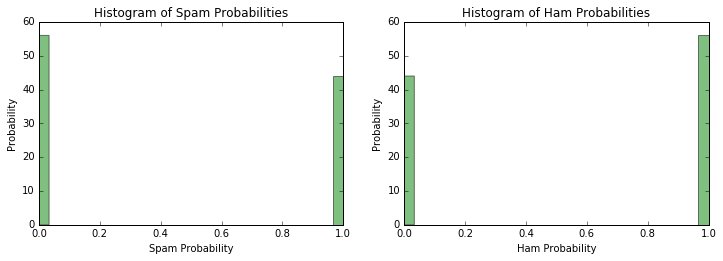

In [18]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import libraries for plotting and analysis
import matplotlib.pyplot as plt
import numpy as np
import re
from decimal import *

# Initialize data structures
doc, Y, prediction, log_prob_spam, log_prob_ham = [], [], [], [], []
classes = ["Spam", "Ham"]

# Read in data from text file
with open('hw2_3_output_predict2.txt', 'r') as myfile:
    for line in myfile:
        fields = line.split()

        # Only look at records that have a doc_id as the first field
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        try:
            key = fields[0]
        except:
            continue
        if pattern.match(fields[0]):
            doc.append(fields[0])
            Y.append(fields[1])
            prediction.append(fields[2])
            log_prob_spam.append(fields[3])
            log_prob_ham.append(fields[4])

# Convert to numpy arrays
doc = np.array(doc)
Y = np.array(Y)
prediction = np.array(prediction)
log_prob_spam = np.array(log_prob_spam).astype(float)
log_prob_ham = np.array(log_prob_ham).astype(float)
log_probs = np.column_stack((log_prob_spam, log_prob_ham))

# These numbers are SO SMALL we need to work with Decimal type, then convert back to float
norm_probs = {0:[], 1:[]}
log_probs_graph = {0:[], 1:[]}

for i in log_probs:
    spam = Decimal(i[0]).exp() / (Decimal(i[0]).exp() + Decimal(i[1]).exp())
    ham = Decimal(i[1]).exp() / (Decimal(i[0]).exp() + Decimal(i[1]).exp())
    norm_probs[0].append(float(spam))
    norm_probs[1].append(float(ham))
    if i[0] != float('-inf'): log_probs_graph[0].append(float(spam))
    if i[1] != float('-inf'): log_probs_graph[1].append(float(ham))

num_bins = 30
plt.figure(figsize=(12, 8))

# Plot histograms
for i in range(2):
    plt.subplot(2, 2, i + 1)
    plt.hist(norm_probs[i], num_bins, facecolor='green', alpha=0.5)
    plt.xlabel(classes[i] + ' Probability')
    plt.ylabel('Probability')
    plt.title(r'Histogram of ' + classes[i] + ' Probabilities')


#### Histogram summary

The histogram of normalized probabilities are either 0 or 1. Because we are not using smoothing, the non-presence of a word in a document renders that prediction's probability to be zero (thus the other class's probability is 1). There are no emails where all words in the document are present in both spam and ham. Thus, for every email, one of the classes will have a zero probability. This results in 0% error rate.

### HW2.4: Repeat HW2.3 with the following modification: use Laplace plus-one smoothing.

#### Mapper/Reducer #1 for fitting NB

Mapper:
- Input: training documents
- Output: (word, 1, 0) if word was in spam, otherwise (word, 0, 1)
  - Special words: \*alldocs, \*docs, \*vocab and \*words
  
Reducer:
- Input: (word, 1, 0) or (word, 0, 1)
- Output: (word, spam count, ham count)

In [399]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.4

import sys
import string
import re

counts = {
    '*words':{
        '1':0,
        '0':0
    },
    '*docs':{
        '1':0,
        '0':0
    }
}
total_docs = 0

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    
    # Keep track of document counts
    spam = fields[1]
    counts['*docs'][spam] += 1
    total_docs += 1
    
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words
    # If word is not trivial, write to file
    # key = word
    # value = 1
    for word in words:
        if len(word) > 0 and repr(word)[1] != '\\':
            if spam == '1':
                print "%s\t%s\t%s" % (word, 1, 0)
            elif spam == '0':
                print "%s\t%s\t%s" % (word, 0, 1)
            counts['*words'][spam] += 1

# At the end, output document and word counts
for item in counts:
    print "%s\t%s\t%s" % (item, counts[item]['1'], counts[item]['0'])
print "%s\t%s\t%s" % ('*alldocs', total_docs, total_docs)

Overwriting mapper.py


In [408]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.4

from operator import itemgetter
import sys
import math

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_spam_count = 0
prev_ham_count = 0
word = None
vocab_size = 0

for line in sys.stdin:
    # Split line into fields
    fields = line.strip().split('\t')
    word = fields[0]
    spam_count = fields[1]
    ham_count = fields[2]
    
    # If possible, turn count into an int (it's read as a string)
    try:
        spam_count = int(spam_count)
        ham_count = int(ham_count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    if prev_word == word:
        # We have not moved to a new word
        # Just update the count of this word
        prev_spam_count += spam_count
        prev_ham_count += ham_count
        
    else:
        # We have encountered a new word!
        # If this is the first word, we don't need to print anything
        if prev_word: 
            # Write the previous word to file
            print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
            if prev_word[0] != '*': vocab_size += 1
            
        # Now we need to initialize our variables
        prev_word = word
        prev_spam_count = spam_count
        prev_ham_count = ham_count

# We've reached the end of the file
# Print the last word and counts
print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
if prev_word[0] != '*': vocab_size += 1
    
# Print the vocab size for this set of words
print '%s\t%s\t%s' % ('*vocab', vocab_size, vocab_size)

Overwriting reducer.py


In [411]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_4_output_fit1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_4_output_fit1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

Deleted /user/miki/week02/hw2_4_output_fit1
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob5743295591766583947.jar tmpDir=null


#### Note:

We are working with a file that is small in size, and so there is only one reducer involved. If there were multiple reducers involved, we would need to run another reducer to sum the values of \*vocab, since we need unique counts.

In [386]:
#!hdfs dfs -cat /user/miki/week02/hw2_4_output_fit1/part-00000

#### Mapper/Reducer #1 for predicting NB

Mapper:
- Input from fit: (word, spam count, ham count)
- Output: (word, spam count, ham count)
- Input testing document: (document ID, cat, subj, body)
- Output: (word, cat, document ID)

Reducer:
- Input: (word, spam count, ham count)
- Input: (word, cat, document ID)
- Output: (document ID, cat, word, spam count, ham count)

In [430]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.4

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields    
    fields = line.strip().split('\t')
    
    # If first field matches pattern of document ID, tokenize words
    pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
    if pattern.match(fields[0]):
        # Keep track of document counts
        doc_id = fields[0]
        spam = fields[1]

        # We are always going to need the doc/word counts for each document
        print '%s^%s^%s' % ('*alldocs', spam, doc_id)
        print '%s^%s^%s' % ('*docs', spam, doc_id)
        print '%s^%s^%s' % ('*words', spam, doc_id)
        print '%s^%s^%s' % ('*vocab', spam, doc_id)
        
        # Replace commas with spaces (we are using commas as a delimiter as well)
        # Remove remaining punctuation from subject and body
        # Concatenate, then split subject and body by spaces
        # Some records are malformed -- if there is a 4th field, use it
        subj = fields[2].replace(',', ' ')
        subj = subj.translate(string.maketrans("",""), string.punctuation)
        if len(fields) == 4:
            body = fields[3].replace(',', ' ')
            body = body.translate(string.maketrans("",""), string.punctuation)
        else:
            body = ""
        words = subj + " " + body
        words = words.split()

        # Loop through words
        # If word is not trivial, write to file
        # key = word
        # value = doc_id
        for word in words:
            if len(word) > 0 and repr(word)[1] != '\\':
                print '%s^%s^%s' % (word, spam, doc_id)
    else:
        # Now we know that the record is the
        #   output of the previous MapReduce job
        #   not the doc we are classifying
        # We append the spam_count with a * so that it comes first
        # We need the overall spam/ham word counts with each word in the doc
        word = fields[0]
        spam_count = fields[1]
        ham_count = fields[2]
        print '%s^%s^%s' % (word, '*' + spam_count, ham_count)


Overwriting mapper.py


In [431]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.4

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
spam_count = 0
ham_count = 0

for line in sys.stdin:
    # Strip and split line
    key, value = line.strip().split('\t')
    word, field1 = key.split('^')

    # If field1 starts with a *, we know that it is the spam and ham counts
    if field1[0] == '*':
        # This record will be of the form (word field1=*spam_count value=ham_count)
        try:
            spam_count = int(field1.replace('*',''))
            ham_count = int(value)
        except ValueError:
            continue
    
    else:
        # Now we know that it is a doc_id record
        # This record will be of the form (word field1=cat value=doc_id)
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        if pattern.match(value):
            doc_id = value
        print '%s\t%s\t%s\t%s\t%s' % (doc_id, field1, word, spam_count, ham_count)

Overwriting reducer.py


In [432]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_4_output_predict1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-input /user/miki/week02/enronemail_1h.txt \
-input /user/miki/week02/hw2_4_output_fit1 \
-output /user/miki/week02/hw2_4_output_predict1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

Deleted /user/miki/week02/hw2_4_output_predict1
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob4524769482412452532.jar tmpDir=null


In [423]:
#!hdfs dfs -cat /user/miki/week02/hw2_4_output_predict1/part-00000

#### Mapper/Reducer #2 for predicting NB

Mapper:
- Input from predict1: (doc_id, cat, word, spam count, ham count)
- Output: identity

Reducer:
- Input: (doc_id, cat, word, spam count, ham count)
- Output: (doc_id, cat, prediction, spam log prob, ham log prob)

In [542]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.4

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Replace delimiter
    line = line.replace('\n', '')
    fields = line.split('\t')
    print '%s^%s^%s^%s^%s' % (fields[0], fields[1], fields[2], fields[3], fields[4])

Overwriting mapper.py


In [543]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.4

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
doc = None
spam = None
count = 1
class_count = {'1':0, '0':0}
word = None

prev_doc = None
prev_spam = None
prev_count = 1
prev_class_count = {'1':0, '0':0}
prev_word = None

vocab = 0
docs_total = 0
docs = {'1':0, '0':0}
words_total = 0
words = {'1':0, '0':0}
log_prior = {'1':0, '0':0}
log_posterior = {'1':0, '0':0}
log_likelihood = {'1':0, '0':0}

classes = {'1':'spam', '0':'ham'}
num_errors = {'1':0, '0':0}
num_total = 0.0
num_correct = 0.0

print_debug = False

# Create a function to update the posterior
# since we need to do it in multiple locations.
# We don't want to duplicate code
def update_posterior():
    for item in classes:
        # This is where we incorporate smoothing
        log_likelihood[item] = math.log((1 + prev_class_count[item]) / (vocab + words[item]))
        log_posterior[item] += prev_count * log_likelihood[item]
        if print_debug:
            print "updated log posterior:", log_posterior[item]
            print '\n'

def make_prediction(): 
    global num_total, num_correct
    
    # We can compare non-normalized posterior probabilities
    num_total += 1
    if log_posterior['1'] > log_posterior['0']: prediction = '1'
    else: prediction = '0'

    # Count correct guesses
    if prev_spam == prediction:
        num_correct += 1
        
    # Output the log posteriors. We can normalize later.
    print '%s\t%s\t%s\t%s\t%s\n' % (prev_doc, prev_spam, prediction, 
                                    log_posterior['1'],
                                    log_posterior['0'])

for line in sys.stdin:
    # Strip and split line
    # Assign variables
    line = line.replace('\n', '')
    
    # Split when testing locally
    #doc, spam, word, count['1'], count['0'] = line.split('\t')
    
    # Split when using Hadoop
    key, value = line.strip().split('\t')
    doc, spam, word = key.split('^')
    class_count['1'], class_count['0'] = value.split('^')    

    # Keep this in a try/except statement so we don't fail
    try:
        for item in classes:
            class_count[item] = float(class_count[item])
    except ValueError:
        continue

    # Let's calculate some probabilities
    if prev_doc == doc:
        # We haven't changed documents
        if prev_word == word:
            # We haven't changed words, so just increment
            prev_count += 1

        else:
            # We are at a new word
            # We need to check if we are at a keyword
            if print_debug: print '\n', prev_word, '\n'
            if prev_word == '*alldocs': 
                # We are at a record where we need to output total docs
                docs_total = prev_class_count['1']
                if print_debug: print "total docs:", docs_total

            elif prev_word == '*docs': 
                # We are at a record where we need to output unique docs per class
                for item in classes:
                    docs[item] = prev_class_count[item]
                    if print_debug: print "prior", item, docs[item], '/', docs_total
                    log_prior[item] = math.log(docs[item] / docs_total)

                    # We will update the posterior after each word
                    # Initialize it to the prior
                    log_posterior[item] = log_prior[item]
                if print_debug: 
                    print "log prior:", log_prior
                    print 'log posterior initial', log_posterior

            elif prev_word == '*words':
                # We are at a record where we need to output words per class
                for item in classes:
                    words[item] = prev_class_count[item]
                words_total = sum(prev_class_count.values())
                if print_debug: print "word class_count:", words
                                
            elif prev_word == '*vocab':
                # We are at a record where we need to output the vocab size
                vocab = prev_class_count['1']
                if print_debug: print "vocab size:", vocab

            elif prev_word:
                # We are at a new normal word, and need to calculate stuff
                update_posterior()

            prev_word = word
            prev_count = 1
            for item in classes:
                prev_class_count[item] = class_count[item]

    else:
        # We are done with one document. We need to: 
        # - process the last word
        # - output our predictions
        if prev_doc:
            if print_debug: print '\n', prev_word, '\n'
            # We are at a new normal word, and need to calculate stuff
            update_posterior()

            # Now we can calculate the prediction
            make_prediction()
            if print_debug: print num_correct, "out of", num_total

        prev_doc = doc
        prev_spam = spam
        prev_word = word
        for item in classes:
            prev_class_count[item] = class_count[item]
        log_likelihood = {'1':0, '0':0}
        if print_debug: print "reset log likelihood"

# Output our final prediction
if print_debug: print '\n', prev_word, '\n'
update_posterior()
make_prediction()

print "Number of documents\t%d" % (num_total)
print "Number correct predictions\t%d" % (num_correct)
print "Error rate\t%s" % (100 - 100 * num_correct / num_total) + "%"
print "Number of zero probability spam\t%d" % (num_errors['1'])
print "Number of zero probability ham\t%d" % (num_errors['0'])

Overwriting reducer.py


In [544]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_4_output_predict2

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,2 \
-input /user/miki/week02/hw2_4_output_predict1/part* \
-output /user/miki/week02/hw2_4_output_predict2 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

Deleted /user/miki/week02/hw2_4_output_predict2
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob5652509028914698936.jar tmpDir=null


In [449]:
#!hdfs dfs -cat /user/miki/week02/hw2_4_output_predict2/part-00000

In [548]:
# Copy files from HDFS
!rm hw2_4_output_predict2.txt
!hdfs dfs -copyToLocal /user/miki/week02/hw2_4_output_predict2/part-00000 \
hw2_4_output_predict2.txt

In [549]:
print_results('hw2_4_output_predict2.txt')

Document                       Truth     Predicted    Log Prob Spam   Log Prob Ham
----------------------------------------------------------------------------------
0001.1999-12-10.farmer           0           0           -47.096765     -44.164126
0001.1999-12-10.kaminski         0           0           -32.156825     -29.786564
0001.2000-01-17.beck             0           0         -3784.543066   -3423.100066
0001.2000-06-06.lokay            0           0         -4047.517444   -3618.247343
0001.2001-02-07.kitchen          0           0          -350.817691    -305.204350
0001.2001-04-02.williams         0           0         -1412.267544   -1366.134284
0002.1999-12-13.farmer           0           0         -3090.293822   -2744.595250
0002.2001-02-07.kitchen          0           0          -463.594975    -449.426584
0002.2001-05-25.SA_and_HP        1           1          -586.481375    -641.071290
0002.2003-12-18.GP               1           1         -1275.748087   -1394.091408
0002

#### Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

Both error rates for 2.3 and 2.4 are zero. In 2.3, if we run into a zero probability issue, the probability for that class's prediction will be zero, so the normalized probabilities are 0 or 1. In 2.4, we have probabilities that are between 0 and 1, not equal to 0 or 1. However, both result in a 0% error rate.

Since we are training and testing on the same data set, we likely are missing any significant differences in the two models.

### HW2.5: Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. 

#### Mapper/Reducer #1 for fitting NB

Mapper:
- Input: training documents
- Output: (word, 1, 0) if word was in spam, otherwise (word, 0, 1)
  - Special words: \*alldocs, \*docs, \*vocab and \*words
  
Reducer:
- Input: (word, 1, 0) or (word, 0, 1)
- Output: (word, spam count, ham count)

In [550]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.5

import sys
import string
import re

counts = {
    '*words':{
        '1':0,
        '0':0
    },
    '*docs':{
        '1':0,
        '0':0
    }
}
total_docs = 0

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields
    # Replace commas with spaces (we are using commas as a delimiter as well)
    # Remove remaining punctuation from subject and body
    # Concatenate, then split subject and body by spaces
    # Some records are malformed -- if there is a 4th field, use it
    fields = line.strip().split('\t')
    
    # Keep track of document counts
    spam = fields[1]
    counts['*docs'][spam] += 1
    total_docs += 1
    
    subj = fields[2].replace(',', ' ')
    subj = subj.translate(string.maketrans("",""), string.punctuation)
    if len(fields) == 4:
        body = fields[3].replace(',', ' ')
        body = body.translate(string.maketrans("",""), string.punctuation)
    else:
        body = ""
    words = subj + " " + body
    words = words.split()
    
    # Loop through words
    # If word is not trivial, write to file
    # key = word
    # value = 1
    for word in words:
        if len(word) > 0 and repr(word)[1] != '\\':
            if spam == '1':
                print "%s\t%s\t%s" % (word, 1, 0)
            elif spam == '0':
                print "%s\t%s\t%s" % (word, 0, 1)
            counts['*words'][spam] += 1

# At the end, output document and word counts
for item in counts:
    print "%s\t%s\t%s" % (item, counts[item]['1'], counts[item]['0'])
print "%s\t%s\t%s" % ('*alldocs', total_docs, total_docs)

Overwriting mapper.py


In [551]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.5

from operator import itemgetter
import sys
import math

# Initialize some variables
# We know that the words will be sorted
# We need to keep track of state
prev_word = None
prev_spam_count = 0
prev_ham_count = 0
word = None
vocab_size = 0

for line in sys.stdin:
    # Split line into fields
    fields = line.strip().split('\t')
    word = fields[0]
    spam_count = fields[1]
    ham_count = fields[2]
    
    # If possible, turn count into an int (it's read as a string)
    try:
        spam_count = int(spam_count)
        ham_count = int(ham_count)
    except ValueError:
        # We couldn't make count into an int, so move on
        continue
        
    if prev_word == word:
        # We have not moved to a new word
        # Just update the count of this word
        prev_spam_count += spam_count
        prev_ham_count += ham_count
        
    else:
        # We have encountered a new word!
        # If this is the first word, we don't need to print anything
        # Also only print the word and increment if total occurences is >= 3
        if prev_word and prev_spam_count + prev_ham_count >= 3: 
            # Write the previous word to file
            print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
            if prev_word[0] != '*': vocab_size += 1
            
        # Now we need to initialize our variables
        prev_word = word
        prev_spam_count = spam_count
        prev_ham_count = ham_count

# We've reached the end of the file
# Print the last word and counts
print '%s\t%s\t%s' % (prev_word, prev_spam_count, prev_ham_count)
if prev_word[0] != '*': vocab_size += 1
    
# Print the vocab size for this set of words
print '%s\t%s\t%s' % ('*vocab', vocab_size, vocab_size)

Overwriting reducer.py


In [552]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_5_output_fit1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-input /user/miki/week02/enronemail_1h.txt \
-output /user/miki/week02/hw2_5_output_fit1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

rm: `/user/miki/week02/hw2_5_output_fit1': No such file or directory
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob2782948487555149227.jar tmpDir=null


#### Note:

We are working with a file that is small in size, and so there is only one reducer involved. If there were multiple reducers involved, we would need to run another reducer to sum the values of \*vocab, since we need unique counts.

In [386]:
#!hdfs dfs -cat /user/miki/week02/hw2_5_output_fit1/part-00000

#### Mapper/Reducer #1 for predicting NB

Mapper:
- Input from fit: (word, spam count, ham count)
- Output: (word, spam count, ham count)
- Input testing document: (document ID, cat, subj, body)
- Output: (word, cat, document ID)

Reducer:
- Input: (word, spam count, ham count)
- Input: (word, cat, document ID)
- Output: (document ID, cat, word, spam count, ham count)

In [553]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.5

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Strip white space from line, then split into fields    
    fields = line.strip().split('\t')
    
    # If first field matches pattern of document ID, tokenize words
    pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
    if pattern.match(fields[0]):
        # Keep track of document counts
        doc_id = fields[0]
        spam = fields[1]

        # We are always going to need the doc/word counts for each document
        print '%s^%s^%s' % ('*alldocs', spam, doc_id)
        print '%s^%s^%s' % ('*docs', spam, doc_id)
        print '%s^%s^%s' % ('*words', spam, doc_id)
        print '%s^%s^%s' % ('*vocab', spam, doc_id)
        
        # Replace commas with spaces (we are using commas as a delimiter as well)
        # Remove remaining punctuation from subject and body
        # Concatenate, then split subject and body by spaces
        # Some records are malformed -- if there is a 4th field, use it
        subj = fields[2].replace(',', ' ')
        subj = subj.translate(string.maketrans("",""), string.punctuation)
        if len(fields) == 4:
            body = fields[3].replace(',', ' ')
            body = body.translate(string.maketrans("",""), string.punctuation)
        else:
            body = ""
        words = subj + " " + body
        words = words.split()

        # Loop through words
        # If word is not trivial, write to file
        # key = word
        # value = doc_id
        for word in words:
            if len(word) > 0 and repr(word)[1] != '\\':
                print '%s^%s^%s' % (word, spam, doc_id)
    else:
        # Now we know that the record is the
        #   output of the previous MapReduce job
        #   not the doc we are classifying
        # We append the spam_count with a * so that it comes first
        # We need the overall spam/ham word counts with each word in the doc
        word = fields[0]
        spam_count = fields[1]
        ham_count = fields[2]
        print '%s^%s^%s' % (word, '*' + spam_count, ham_count)


Overwriting mapper.py


In [554]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.5

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
spam_count = 0
ham_count = 0

for line in sys.stdin:
    # Strip and split line
    key, value = line.strip().split('\t')
    word, field1 = key.split('^')

    # If field1 starts with a *, we know that it is the spam and ham counts
    if field1[0] == '*':
        # This record will be of the form (word field1=*spam_count value=ham_count)
        try:
            spam_count = int(field1.replace('*',''))
            ham_count = int(value)
        except ValueError:
            continue
    
    else:
        # Now we know that it is a doc_id record
        # This record will be of the form (word field1=cat value=doc_id)
        pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
        if pattern.match(value):
            doc_id = value
        print '%s\t%s\t%s\t%s\t%s' % (doc_id, field1, word, spam_count, ham_count)

Overwriting reducer.py


In [555]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_5_output_predict1

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=2 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-input /user/miki/week02/enronemail_1h.txt \
-input /user/miki/week02/hw2_5_output_fit1 \
-output /user/miki/week02/hw2_5_output_predict1 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

rm: `/user/miki/week02/hw2_5_output_predict1': No such file or directory
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob2643183505328283945.jar tmpDir=null


In [423]:
#!hdfs dfs -cat /user/miki/week02/hw2_5_output_predict1/part-00000

#### Mapper/Reducer #2 for predicting NB

Mapper:
- Input from predict1: (doc_id, cat, word, spam count, ham count)
- Output: identity

Reducer:
- Input: (doc_id, cat, word, spam count, ham count)
- Output: (doc_id, cat, prediction, spam log prob, ham log prob)

In [556]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Miki Seltzer
## Description: mapper code for HW2.5

import sys
import string
import re

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    
    # Replace delimiter
    line = line.replace('\n', '')
    fields = line.split('\t')
    print '%s^%s^%s^%s^%s' % (fields[0], fields[1], fields[2], fields[3], fields[4])

Overwriting mapper.py


In [557]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Miki Seltzer
## Description: reducer code for HW2.5

from operator import itemgetter
import sys
import math
import re

# Initialize some variables
doc = None
spam = None
count = 1
class_count = {'1':0, '0':0}
word = None

prev_doc = None
prev_spam = None
prev_count = 1
prev_class_count = {'1':0, '0':0}
prev_word = None

vocab = 0
docs_total = 0
docs = {'1':0, '0':0}
words_total = 0
words = {'1':0, '0':0}
log_prior = {'1':0, '0':0}
log_posterior = {'1':0, '0':0}
log_likelihood = {'1':0, '0':0}

classes = {'1':'spam', '0':'ham'}
num_errors = {'1':0, '0':0}
num_total = 0.0
num_correct = 0.0

print_debug = False

# Create a function to update the posterior
# since we need to do it in multiple locations.
# We don't want to duplicate code
def update_posterior():
    for item in classes:
        # This is where we incorporate smoothing
        log_likelihood[item] = math.log((1 + prev_class_count[item]) / (vocab + words[item]))
        log_posterior[item] += prev_count * log_likelihood[item]
        if print_debug:
            print "updated log posterior:", log_posterior[item]
            print '\n'

def make_prediction(): 
    global num_total, num_correct
    
    # We can compare non-normalized posterior probabilities
    num_total += 1
    if log_posterior['1'] > log_posterior['0']: prediction = '1'
    else: prediction = '0'

    # Count correct guesses
    if prev_spam == prediction:
        num_correct += 1
        
    # Output log posteriors. We can normalize later.
    print '%s\t%s\t%s\t%s\t%s\n' % (prev_doc, prev_spam, prediction, 
                                    log_posterior['1'],
                                    log_posterior['0'])

for line in sys.stdin:
    line = line.replace('\n', '')
    
    #Split when testing locally
    #doc, spam, word, count['1'], count['0'] = line.split('\t')
    
    # Split when using Hadoop
    key, value = line.strip().split('\t')
    doc, spam, word = key.split('^')
    class_count['1'], class_count['0'] = value.split('^')    

    # Keep this in a try/except statement so we don't fail
    try:
        for item in classes:
            class_count[item] = float(class_count[item])
    except ValueError:
        continue

    # Let's calculate some probabilities
    if prev_doc == doc:
        # We haven't changed documents
        if prev_word == word:
            # We haven't changed words, so just increment
            prev_count += 1

        else:
            # We are at a new word
            # We need to check if we are at a keyword
            if print_debug: print '\n', prev_word, '\n'
            if prev_word == '*alldocs': 
                # We are at a record where we need to output total docs
                docs_total = prev_class_count['1']
                if print_debug: print "total docs:", docs_total

            elif prev_word == '*docs': 
                # We are at a record where we need to output unique docs per class
                for item in classes:
                    docs[item] = prev_class_count[item]
                    if print_debug: print "prior", item, docs[item], '/', docs_total
                    log_prior[item] = math.log(docs[item] / docs_total)

                    # We will update the posterior after each word
                    # Initialize it to the prior
                    log_posterior[item] = log_prior[item]
                if print_debug: 
                    print "log prior:", log_prior
                    print 'log posterior initial', log_posterior

            elif prev_word == '*words':
                # We are at a record where we need to output words per class
                for item in classes:
                    words[item] = prev_class_count[item]
                words_total = sum(prev_class_count.values())
                if print_debug: print "word class_count:", words
                                
            elif prev_word == '*vocab':
                # We are at a record where we need to output the vocab size
                vocab = prev_class_count['1']
                if print_debug: print "vocab size:", vocab

            elif prev_word:
                # We are at a new normal word, and need to calculate stuff
                update_posterior()

            prev_word = word
            prev_count = 1
            for item in classes:
                prev_class_count[item] = class_count[item]

    else:
        # We are done with one document. We need to: 
        # - process the last word
        # - output our predictions
        if prev_doc:
            if print_debug: print '\n', prev_word, '\n'
            # We are at a new normal word, and need to calculate stuff
            update_posterior()

            # Now we can calculate the prediction
            make_prediction()
            if print_debug: print num_correct, "out of", num_total

        prev_doc = doc
        prev_spam = spam
        prev_word = word
        for item in classes:
            prev_class_count[item] = class_count[item]
        log_likelihood = {'1':0, '0':0}
        if print_debug: print "reset log likelihood"

# Output our final prediction
if print_debug: print '\n', prev_word, '\n'
update_posterior()
make_prediction()

print "Number of documents\t%d" % (num_total)
print "Number correct predictions\t%d" % (num_correct)
print "Error rate\t%s" % (100 - 100 * num_correct / num_total) + "%"
print "Number of zero probability spam\t%d" % (num_errors['1'])
print "Number of zero probability ham\t%d" % (num_errors['0'])

Overwriting reducer.py


In [558]:
# Change permissions on mapper and reducer
!chmod +x mapper.py
!chmod +x reducer.py

# Delete output folder if it exists
!hdfs dfs -rm -r /user/miki/week02/hw2_5_output_predict2

# Run job
!hadoop jar hadoop-streaming-2.7.1.jar \
-D stream.map.output.field.separator=^ \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.map.output.key.field.separator=^ \
-D mapreduce.partition.keypartitioner.options=-k1,2 \
-input /user/miki/week02/hw2_5_output_predict1/part* \
-output /user/miki/week02/hw2_5_output_predict2 \
-mapper /home/cloudera/Documents/W261-Fall2016/Week02/mapper.py \
-reducer /home/cloudera/Documents/W261-Fall2016/Week02/reducer.py 

rm: `/user/miki/week02/hw2_5_output_predict2': No such file or directory
packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.5.0.jar] /tmp/streamjob4882416490496642420.jar tmpDir=null


In [449]:
#!hdfs dfs -cat /user/miki/week02/hw2_4_output_predict2/part-00000

In [559]:
# Copy files from HDFS
!rm hw2_5_output_predict2.txt
!hdfs dfs -copyToLocal /user/miki/week02/hw2_5_output_predict2/part-00000 \
hw2_5_output_predict2.txt

rm: cannot remove `hw2_5_output_predict2.txt': No such file or directory


In [560]:
print_results('hw2_5_output_predict2.txt')

Document                       Truth     Predicted    Log Prob Spam   Log Prob Ham
----------------------------------------------------------------------------------
0001.1999-12-10.farmer           0           0           -44.424640     -42.613368
0001.1999-12-10.kaminski         0           0           -31.452532     -27.260891
0001.2000-01-17.beck             0           0         -3598.936015   -3274.082617
0001.2000-06-06.lokay            0           0         -3875.694850   -3453.212023
0001.2001-02-07.kitchen          0           0          -335.955246    -296.184093
0001.2001-04-02.williams         0           0         -1341.716585   -1306.951502
0002.1999-12-13.farmer           0           0         -2920.512866   -2632.211214
0002.2001-02-07.kitchen          0           0          -442.933630    -429.812761
0002.2001-05-25.SA_and_HP        1           1          -557.808327    -603.814689
0002.2003-12-18.GP               1           1         -1204.417793   -1306.522525
0002

#### How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset?

Excluding words that occur fewer than three times increases our error rate to 2%. This is because we are excluding information from our model, so there is more chance for the model to make a mistake. However, including all of the information can be considered a form of overfitting, so removing these rarely-occurring words may make the model more robust.

### HW2.6: Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

- Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error

In [19]:
# General libraries
from __future__ import division

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [20]:
# Read data in and create data and label arrays
ids, X, Y = [], [], []

with open('enronemail_1h.txt', 'r') as myfile:
    for line in myfile:
        fields = line.split("\t")
        
        # Some records are malformed, so make sure that we take the right fields
        subj, body = "", ""
        
        if len(fields) >= 3:
            subj = fields[2]
        if len(fields) >= 4:
            body = fields[3]

        text = subj + " " + body
        text = text.replace("\n", "")
        X.append(text)
        Y.append(fields[1])
        ids.append(fields[0])

# Convert these to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Check that the shapes look correct
print X.shape, Y.shape

(100,) (100,)


In [21]:
def hw2_6():
    train_errors = []
    
    ##### MULTINOMIAL NB
    # Create Pipeline to get feature vectors and train
    # Use CountVectorizer to get feature arrays
    # Classify using Multinomial NB
    mnb_pipe = Pipeline([('vect', CountVectorizer()),
                         ('clf', MultinomialNB()),
                        ])

    # Fit training data and labels
    mnb_pipe.fit(X, Y)

    # Print training error
    mnb_predictions = mnb_pipe.predict(X)
    train_errors.append(["SK-learn with alpha=1",sum(mnb_predictions != Y) / Y.size])
    
    ##### MULTINOMIAL NB WITH MIN_DF
    # This should exclude words that do not meet a minimum frequency
    
    mnb_pipe.set_params(vect__min_df=3, clf__fit_prior=True)
    
    # Fit training data and labels
    mnb_pipe.fit(X, Y)
    
    # Print training error
    mnb_predictions = mnb_pipe.predict(X)
    train_errors.append(["SK-learn with min_df=3",sum(mnb_predictions != Y) / Y.size])
    
    
    ##### CLASSIFIER in HW2.3
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('hw2_3_output_predict2.txt', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors.append(["HW2.3 (no smoothing)",incorrect/total])
    
    
    ##### CLASSIFIER in HW2.4
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('hw2_4_output_predict2.txt', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors.append(["HW2.4 (+1 smoothing)",incorrect/total])
    
    ##### CLASSIFIER in HW2.5
    # Read output from results
    
    incorrect = 0.0
    total = 0.0

    # Read in data from text file
    with open('hw2_5_output_predict2.txt', 'r') as myfile:
        for line in myfile:
            fields = line.split()

            # Only look at records that have a doc_id as the first field
            pattern = re.compile('^\d{4}.\d{4}-\d{2}-\d{2}\.\w+')
            try:
                key = fields[0]
            except:
                continue
            if pattern.match(fields[0]):
                total += 1
                if fields[1] != fields[2]: incorrect += 1
    
    train_errors.append(["HW2.5 (drop words <3)",incorrect/total])
    
    ##### TABLE OF TRAINING ERRORS
    print "{:<25s}{:>6s}".format("Method", "Error")
    print "--------------------------------"
    for method in train_errors:
        print "{:<25s}{:>6.0%}".format(method[0], method[1])
    
hw2_6()

Method                    Error
--------------------------------
SK-learn with alpha=1        0%
SK-learn with min_df=3       4%
HW2.3 (no smoothing)         0%
HW2.4 (+1 smoothing)         0%
HW2.5 (drop words <3)        2%


#### Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn

We can compare the default SK-learn MultinomialNB classifier with alpha=1 to ours in question 2.4 (Laplace +1 smoothing). In both of these classifiers, the error rate is 0%.

We can also compare the SK-learn classifier with min_df=3 to our classifier in question 2.5. In this case, the SK-learn classifier has a 4% error rate, while ours has a 2% error rate. There may be difference in the way that the words are tokenized (in SK-learn, I used CountVectorizer with min_df=3). 

By default, SK-learn does not fit a prior probability, but instead uses a uniform prior probability. This might result in a small difference, however, when I used the option to fit a prior in SK-learn, the resulting error rate was no different than using a uniform prior (the default).